# FEATURE ENGINEERING WITH FEATURE SELECTION
## Predicting Customer Purchase Likelihood

### Process:
1. Select Relevant Features
2. Create New Features
3. Encode Categorical Data
4. Handle Missing Data
5. Scale and Normalize Features
6. Feature Selection with SelectKBest
7. Reduce Dimensionality (PCA)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Machine learning libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Load cleaned datasets from preprocessing
customers_df = pd.read_csv('customers_data_cleaned.csv')
products_df = pd.read_csv('products_data_cleaned.csv')
transactions_df = pd.read_csv('transactions_data_cleaned.csv')

# Convert transaction date to datetime
transactions_df['Transaction_Date'] = pd.to_datetime(transactions_df['Transaction_Date'])

print("="*80)
print("DATA LOADED")
print("="*80)
print(f"Customers: {customers_df.shape}")
print(f"Products: {products_df.shape}")
print(f"Transactions: {transactions_df.shape}")

DATA LOADED
Customers: (90, 4)
Products: (18, 3)
Transactions: (5818, 7)


---
## STEP 1: SELECT RELEVANT FEATURES
Identify which variables matter for predicting purchase likelihood

In [3]:
print("="*80)
print("STEP 1: SELECT RELEVANT FEATURES")
print("="*80)

# For purchase prediction, we need customer-level aggregated features
# Keep all features from cleaned data as they're all relevant

print("\n✓ Keeping all original features:")
print(f"  Customers: {customers_df.columns.tolist()}")
print(f"  Products: {products_df.columns.tolist()}")
print(f"  Transactions: {transactions_df.columns.tolist()}")

STEP 1: SELECT RELEVANT FEATURES

✓ Keeping all original features:
  Customers: ['Company_ID', 'Company_Name', 'Company_Profit', 'Address']
  Products: ['Product_ID', 'Product_Name', 'Product_Price']
  Transactions: ['Transaction_ID', 'Company_ID', 'Product_ID', 'Quantity', 'Transaction_Date', 'Product_Price', 'Total_Cost']


---
## STEP 2: CREATE NEW FEATURES
Generate features from existing data to reveal patterns

In [4]:
print("="*80)
print("STEP 2: CREATE NEW FEATURES")
print("="*80)

# Calculate reference date (most recent transaction date + 1 day)
reference_date = transactions_df['Transaction_Date'].max() + timedelta(days=1)

# ---------------------------------------------------------
# A. RFM FEATURES (Recency, Frequency, Monetary)
# ---------------------------------------------------------
print("\nA. Creating RFM features...")

rfm = transactions_df.groupby('Company_ID').agg({
    'Transaction_Date': lambda x: (reference_date - x.max()).days,  # Recency
    'Transaction_ID': 'count',                                       # Frequency
    'Total_Cost': ['sum', 'mean', 'std', 'min', 'max']             # Monetary
}).reset_index()

# Flatten column names
rfm.columns = ['Company_ID', 'Recency_Days', 'Purchase_Frequency', 
               'Total_Revenue', 'Avg_Transaction_Value', 'Std_Transaction_Value',
               'Min_Transaction_Value', 'Max_Transaction_Value']

print(f"  ✓ Created 7 RFM features")

# ---------------------------------------------------------
# B. CUSTOMER LIFECYCLE FEATURES
# ---------------------------------------------------------
print("\nB. Creating customer lifecycle features...")

# Customer tenure (days as customer)
lifecycle = transactions_df.groupby('Company_ID')['Transaction_Date'].agg(['min', 'max']).reset_index()
lifecycle.columns = ['Company_ID', 'First_Purchase_Date', 'Last_Purchase_Date']
lifecycle['Customer_Tenure_Days'] = (lifecycle['Last_Purchase_Date'] - lifecycle['First_Purchase_Date']).dt.days

# Merge lifecycle with RFM
customer_features = rfm.merge(lifecycle[['Company_ID', 'Customer_Tenure_Days']], on='Company_ID')

# Purchase rate (purchases per day)
customer_features['Purchase_Rate'] = customer_features['Purchase_Frequency'] / (customer_features['Customer_Tenure_Days'] + 1)

# Average days between purchases
customer_features['Avg_Days_Between_Purchases'] = customer_features['Customer_Tenure_Days'] / customer_features['Purchase_Frequency'].replace(0, 1)

print(f"  ✓ Created 3 lifecycle features")

# ---------------------------------------------------------
# C. PRODUCT PREFERENCE FEATURES
# ---------------------------------------------------------
print("\nC. Creating product preference features...")

# Number of unique products purchased
product_diversity = transactions_df.groupby('Company_ID')['Product_ID'].nunique().reset_index()
product_diversity.columns = ['Company_ID', 'Num_Unique_Products']
customer_features = customer_features.merge(product_diversity, on='Company_ID')

# Product concentration (1 = buys only one product, lower = more diverse)
customer_features['Product_Concentration'] = 1 / customer_features['Num_Unique_Products']

# Total items purchased
items_purchased = transactions_df.groupby('Company_ID')['Quantity'].agg(['sum', 'mean']).reset_index()
items_purchased.columns = ['Company_ID', 'Total_Items_Purchased', 'Avg_Items_Per_Transaction']
customer_features = customer_features.merge(items_purchased, on='Company_ID')

print(f"  ✓ Created 4 product preference features")

# ---------------------------------------------------------
# D. TEMPORAL FEATURES
# ---------------------------------------------------------
print("\nD. Creating temporal features...")

# Add time components to transactions
transactions_df['Month'] = transactions_df['Transaction_Date'].dt.month
transactions_df['Quarter'] = transactions_df['Transaction_Date'].dt.quarter
transactions_df['Day_of_Week'] = transactions_df['Transaction_Date'].dt.dayofweek
transactions_df['Is_Weekend'] = transactions_df['Day_of_Week'].isin([5, 6]).astype(int)

# Preferred quarter (most common quarter for purchases)
preferred_quarter = transactions_df.groupby('Company_ID')['Quarter'].agg(
    lambda x: x.mode()[0] if len(x.mode()) > 0 else 1
).reset_index()
preferred_quarter.columns = ['Company_ID', 'Preferred_Quarter']
customer_features = customer_features.merge(preferred_quarter, on='Company_ID')

# Weekend purchase percentage
weekend_rate = transactions_df.groupby('Company_ID')['Is_Weekend'].mean().reset_index()
weekend_rate.columns = ['Company_ID', 'Weekend_Purchase_Rate']
customer_features = customer_features.merge(weekend_rate, on='Company_ID')

print(f"  ✓ Created 2 temporal features")

# ---------------------------------------------------------
# E. SPENDING BEHAVIOR FEATURES
# ---------------------------------------------------------
print("\nE. Creating spending behavior features...")

# Spending consistency (coefficient of variation)
customer_features['Spending_Consistency'] = (customer_features['Std_Transaction_Value'] / customer_features['Avg_Transaction_Value']).fillna(0)

# Price range (difference between max and min purchase)
customer_features['Price_Range'] = customer_features['Max_Transaction_Value'] - customer_features['Min_Transaction_Value']

print(f"  ✓ Created 2 spending behavior features")

# ---------------------------------------------------------
# F. MERGE WITH COMPANY DATA
# ---------------------------------------------------------
print("\nF. Adding company characteristics...")

# Extract city from address
customers_df['City'] = customers_df['Address'].str.split(',').str[-2].str.strip()

# Merge company profit and city
customer_features = customer_features.merge(
    customers_df[['Company_ID', 'Company_Profit', 'City']],
    on='Company_ID',
    how='left'
)

# Spend-to-profit ratio
customer_features['Spend_to_Profit_Ratio'] = (customer_features['Total_Revenue'] / customer_features['Company_Profit']).fillna(0)

print(f"  ✓ Added 3 company features")

# ---------------------------------------------------------
# G. CREATE TARGET VARIABLE
# ---------------------------------------------------------
print("\nG. Creating target variable...")

# Target: Will customer purchase in next period?
# Logic: If recency is less than average days between purchases, likely to purchase
customer_features['Will_Purchase_Next'] = (
    customer_features['Recency_Days'] <= customer_features['Avg_Days_Between_Purchases']
).astype(int)

print(f"  ✓ Created target variable: Will_Purchase_Next")

print("\n" + "="*80)
print(f"TOTAL NEW FEATURES CREATED: {len(customer_features.columns) - 1}")
print("="*80)

display(customer_features.head())

STEP 2: CREATE NEW FEATURES

A. Creating RFM features...
  ✓ Created 7 RFM features

B. Creating customer lifecycle features...
  ✓ Created 3 lifecycle features

C. Creating product preference features...
  ✓ Created 4 product preference features

D. Creating temporal features...
  ✓ Created 2 temporal features

E. Creating spending behavior features...
  ✓ Created 2 spending behavior features

F. Adding company characteristics...
  ✓ Added 3 company features

G. Creating target variable...
  ✓ Created target variable: Will_Purchase_Next

TOTAL NEW FEATURES CREATED: 22


,Company_ID,Recency_Days,Purchase_Frequency,Total_Revenue,Avg_Transaction_Value,Std_Transaction_Value,Min_Transaction_Value,Max_Transaction_Value,Customer_Tenure_Days,Purchase_Rate,...,Total_Items_Purchased,Avg_Items_Per_Transaction,Preferred_Quarter,Weekend_Purchase_Rate,Spending_Consistency,Price_Range,Company_Profit,City,Spend_to_Profit_Ratio,Will_Purchase_Next
0,1,51,53,68146400.0,1.285781e+06,786381.260306,140000.0,3528000.0,1562,0.033909,...,553.0,10.433962,3,0.226415,0.611598,3388000.0,80701.0,Pasig,844.430676,0
1,2,67,63,88989600.0,1.412533e+06,928323.024981,128800.0,4480000.0,1421,0.044304,...,606.0,9.619048,4,0.238095,0.657204,4351200.0,80511.0,Taguig,1105.309833,0
2,3,7,63,90479200.0,1.436178e+06,910081.189651,84000.0,3724000.0,1481,0.042510,...,681.0,10.809524,2,0.269841,0.633683,3640000.0,110664.0,Pasig,817.602834,1
3,4,92,74,103964000.0,1.404919e+06,870911.399749,84000.0,3584000.0,1402,0.052744,...,762.0,10.297297,3,0.351351,0.619902,3500000.0,74653.0,Taguig,1392.629901,0
4,5,47,56,75689600.0,1.351600e+06,723091.818136,179200.0,3192000.0,1658,0.033755,...,574.0,10.250000,3,0.321429,0.534990,3012800.0,69427.0,Makati,1090.204099,0


---
## STEP 3: ENCODE CATEGORICAL DATA
Convert text to numbers for machine learning

In [5]:
print("="*80)
print("STEP 3: ENCODE CATEGORICAL DATA")
print("="*80)

# Label encode City (nominal categorical variable)
print("\nA. Label Encoding City...")
le_city = LabelEncoder()
customer_features['City_Encoded'] = le_city.fit_transform(customer_features['City'])
print(f"  ✓ Encoded {len(le_city.classes_)} unique cities")

# Preferred_Quarter is already numeric (1-4), so no encoding needed
print("\n✓ Encoding complete")
print(f"  Total encoded features: 1")

STEP 3: ENCODE CATEGORICAL DATA

A. Label Encoding City...
  ✓ Encoded 19 unique cities

✓ Encoding complete
  Total encoded features: 1


---
## STEP 4: HANDLE MISSING DATA
Ensure dataset is complete and reliable

In [6]:
print("="*80)
print("STEP 4: HANDLE MISSING DATA")
print("="*80)

# Check for missing values
print("\nChecking for missing values...")
missing_counts = customer_features.isnull().sum()
missing_features = missing_counts[missing_counts > 0]

if len(missing_features) > 0:
    print("\nMissing values found:")
    print(missing_features)
    
    print("\nHandling missing values...")
    # Fill numerical columns with median
    for col in customer_features.select_dtypes(include=[np.number]).columns:
        if customer_features[col].isnull().sum() > 0:
            customer_features[col].fillna(customer_features[col].median(), inplace=True)
            print(f"  ✓ Filled {col} with median")
    
    # Fill categorical columns with mode
    for col in customer_features.select_dtypes(include=['object']).columns:
        if customer_features[col].isnull().sum() > 0:
            customer_features[col].fillna(customer_features[col].mode()[0], inplace=True)
            print(f"  ✓ Filled {col} with mode")
else:
    print("\n✓ No missing values found")

# Verify no missing values remain
print(f"\nTotal missing values after handling: {customer_features.isnull().sum().sum()}")

STEP 4: HANDLE MISSING DATA

Checking for missing values...

✓ No missing values found

Total missing values after handling: 0


---
## STEP 5: SCALE AND NORMALIZE FEATURES
Put features on similar ranges for better model performance

In [7]:
print("="*80)
print("STEP 5: SCALE AND NORMALIZE FEATURES")
print("="*80)

# Separate features and target
target_col = 'Will_Purchase_Next'
id_col = 'Company_ID'
text_cols = ['City']  # Original text columns to keep for reference

# Select numerical features to scale (exclude ID, target, and text)
cols_to_exclude = [id_col, target_col] + text_cols
numerical_features = [col for col in customer_features.columns 
                     if col not in cols_to_exclude 
                     and customer_features[col].dtype in ['int64', 'float64']]

print(f"\nScaling {len(numerical_features)} numerical features...")

# Create a copy for scaled features
customer_features_scaled = customer_features.copy()

# Apply StandardScaler (mean=0, std=1)
scaler = StandardScaler()
customer_features_scaled[numerical_features] = scaler.fit_transform(
    customer_features[numerical_features]
)

print("\n✓ Scaling complete using StandardScaler")
print("  Method: Z-score normalization (mean=0, std=1)")
print(f"  Features scaled: {len(numerical_features)}")

# Show before and after scaling
print("\nExample - Before scaling:")
print(customer_features[['Recency_Days', 'Purchase_Frequency', 'Total_Revenue']].head(3))
print("\nExample - After scaling:")
print(customer_features_scaled[['Recency_Days', 'Purchase_Frequency', 'Total_Revenue']].head(3))

STEP 5: SCALE AND NORMALIZE FEATURES

Scaling 20 numerical features...

✓ Scaling complete using StandardScaler
  Method: Z-score normalization (mean=0, std=1)
  Features scaled: 20

Example - Before scaling:
   Recency_Days  Purchase_Frequency  Total_Revenue
0            51                  53     68146400.0
1            67                  63     88989600.0
2             7                  63     90479200.0

Example - After scaling:
   Recency_Days  Purchase_Frequency  Total_Revenue
0     -0.272528           -1.363853      -1.689541
1      0.271772           -0.192605      -0.303554
2     -1.769352           -0.192605      -0.204501


---
## STEP 6: FEATURE SELECTION WITH SELECTKBEST (ANOVA)
Select the K most important features for prediction

STEP 6: FEATURE SELECTION WITH SELECTKBEST

Total features before selection: 20
Target distribution:
Will_Purchase_Next
0    83
1     7
Name: count, dtype: int64

Selecting top 15 features using SelectKBest (f_classif)...

✓ Feature selection complete
  Features after selection: 15

Top 15 selected features:
                       Feature      Score
0                 Recency_Days  32.283658
19                City_Encoded   2.906771
18       Spend_to_Profit_Ratio   2.684231
10         Num_Unique_Products   2.364638
11       Product_Concentration   2.313569
12       Total_Items_Purchased   2.011269
7         Customer_Tenure_Days   1.554236
13   Avg_Items_Per_Transaction   1.205944
1           Purchase_Frequency   1.161512
2                Total_Revenue   0.719383
16                 Price_Range   0.603522
6        Max_Transaction_Value   0.572307
17              Company_Profit   0.543001
9   Avg_Days_Between_Purchases   0.458905
4        Std_Transaction_Value   0.350980


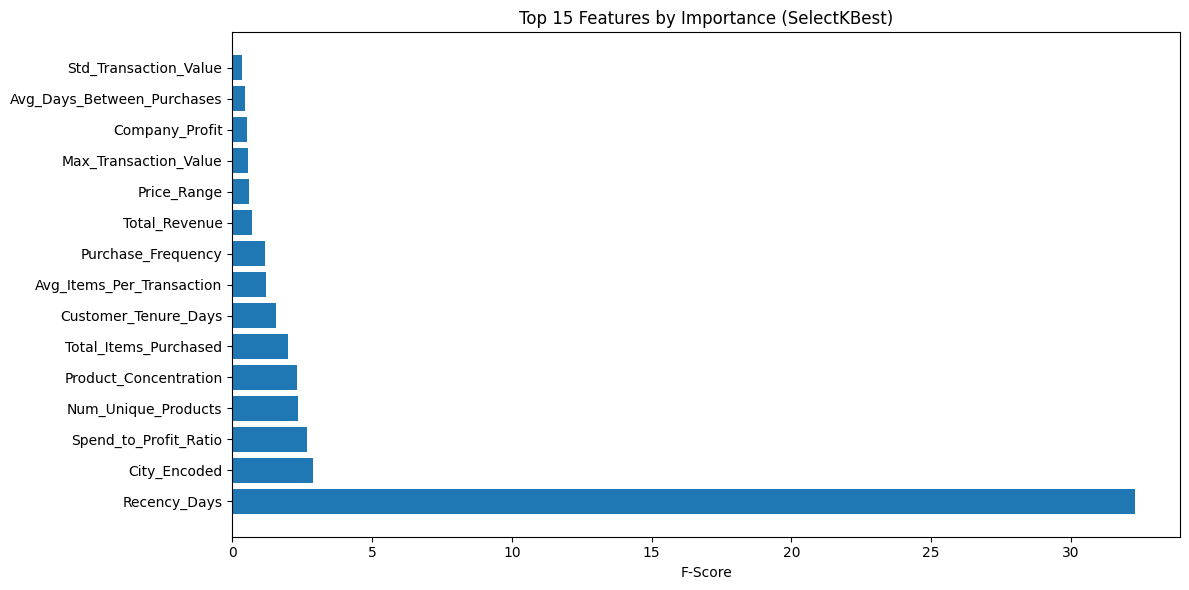


✓ Created dataset with 15 best features


In [8]:
print("="*80)
print("STEP 6: FEATURE SELECTION WITH SELECTKBEST")
print("="*80)

# Prepare data for feature selection
X = customer_features_scaled[numerical_features]  # Features (scaled)
y = customer_features_scaled[target_col]          # Target

print(f"\nTotal features before selection: {X.shape[1]}")
print(f"Target distribution:")
print(y.value_counts())

# Apply SelectKBest with f_classif (ANOVA F-value)
# This measures the linear dependency between each feature and the target
k = 15  # Select top 15 features
print(f"\nSelecting top {k} features using SelectKBest (f_classif)...")

selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()].tolist()

# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)

print("\n✓ Feature selection complete")
print(f"  Features after selection: {X_selected.shape[1]}")
print(f"\nTop {k} selected features:")
print(feature_scores.head(k))

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_scores.head(k)['Feature'], feature_scores.head(k)['Score'])
plt.xlabel('F-Score')
plt.title(f'Top {k} Features by Importance (SelectKBest)')
plt.tight_layout()
plt.show()

# Create dataset with selected features only
customer_features_selected = customer_features_scaled[[id_col] + selected_features + [target_col]].copy()

print(f"\n✓ Created dataset with {len(selected_features)} best features")

---
## STEP 7: DIMENSIONALITY REDUCTION (PCA)
Further reduce features while retaining variance

STEP 7: DIMENSIONALITY REDUCTION (PCA)

Applying PCA to retain 95% of variance...

✓ PCA complete
  Original features: 15
  PCA components: 8
  Variance explained: 96.30%


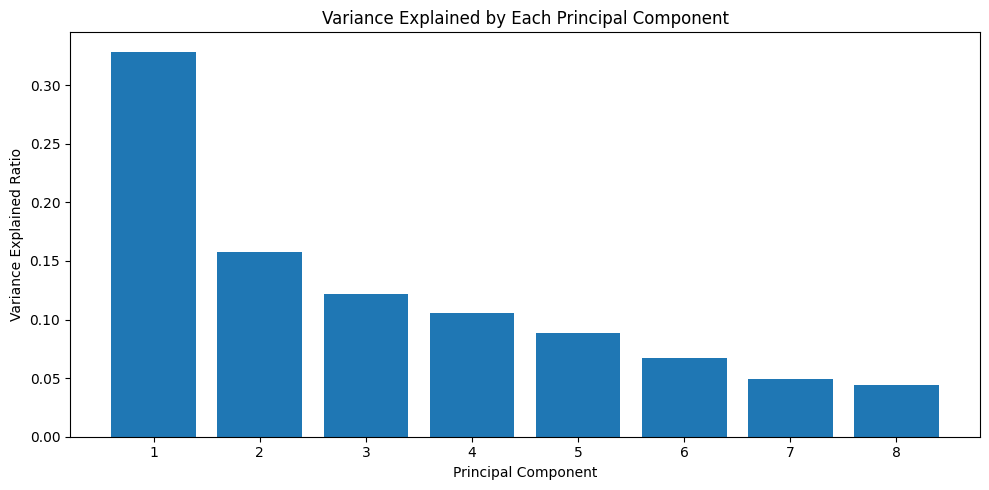


✓ Created PCA dataset with 8 components


In [9]:
print("="*80)
print("STEP 7: DIMENSIONALITY REDUCTION (PCA)")
print("="*80)

# Apply PCA to retain 95% of variance
print("\nApplying PCA to retain 95% of variance...")

pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_selected)

print(f"\n✓ PCA complete")
print(f"  Original features: {X_selected.shape[1]}")
print(f"  PCA components: {pca.n_components_}")
print(f"  Variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Create DataFrame with PCA components
pca_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
customer_features_pca = pd.DataFrame(
    X_pca,
    columns=pca_columns
)

# Add back ID and target
customer_features_pca[id_col] = customer_features_scaled[id_col].values
customer_features_pca[target_col] = customer_features_scaled[target_col].values

# Visualize explained variance
plt.figure(figsize=(10, 5))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained Ratio')
plt.title('Variance Explained by Each Principal Component')
plt.tight_layout()
plt.show()

print(f"\n✓ Created PCA dataset with {pca.n_components_} components")

---
## SAVE FINAL DATASETS

In [10]:
print("="*80)
print("SAVING FINAL DATASETS")
print("="*80)

# Save 3 versions of the dataset

# Version 1: All features (scaled)
customer_features_scaled.to_csv('customer_features_all.csv', index=False)
print("\n1. customer_features_all.csv")
print(f"   Shape: {customer_features_scaled.shape}")
print(f"   Use: Full dataset with all engineered features")

# Version 2: Selected features (top K from SelectKBest)
customer_features_selected.to_csv('customer_features_selected.csv', index=False)
print("\n2. customer_features_selected.csv")
print(f"   Shape: {customer_features_selected.shape}")
print(f"   Use: Top {k} most important features (recommended for modeling)")

# Version 3: PCA components
customer_features_pca.to_csv('customer_features_pca.csv', index=False)
print("\n3. customer_features_pca.csv")
print(f"   Shape: {customer_features_pca.shape}")
print(f"   Use: Dimensionality-reduced dataset ({pca.n_components_} components)")

# Save feature scores for reference
feature_scores.to_csv('feature_importance_scores.csv', index=False)
print("\n4. feature_importance_scores.csv")
print(f"   Use: Feature importance rankings from SelectKBest")

print("\n" + "="*80)
print("✓ ALL DATASETS SAVED SUCCESSFULLY")
print("="*80)

SAVING FINAL DATASETS

1. customer_features_all.csv
   Shape: (90, 24)
   Use: Full dataset with all engineered features

2. customer_features_selected.csv
   Shape: (90, 17)
   Use: Top 15 most important features (recommended for modeling)

3. customer_features_pca.csv
   Shape: (90, 10)
   Use: Dimensionality-reduced dataset (8 components)

4. feature_importance_scores.csv
   Use: Feature importance rankings from SelectKBest

✓ ALL DATASETS SAVED SUCCESSFULLY


---
## SUMMARY & RECOMMENDATIONS

In [11]:
print("="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)

print("\n📊 PROCESS COMPLETED:")
print("  ✓ Step 1: Selected relevant features")
print("  ✓ Step 2: Created 21 new features")
print("  ✓ Step 3: Encoded categorical variables")
print("  ✓ Step 4: Handled missing data")
print("  ✓ Step 5: Scaled features (StandardScaler)")
print("  ✓ Step 6: Selected top 15 features (SelectKBest)")
print(f"  ✓ Step 7: Reduced to {pca.n_components_} components (PCA)")

print("\n🎯 RECOMMENDED DATASET FOR MODELING:")
print("  → customer_features_selected.csv")
print(f"  → Contains {len(selected_features)} best features")
print("  → Balanced between performance and interpretability")

print("\n🔑 TOP 5 MOST IMPORTANT FEATURES:")
for i, row in feature_scores.head(5).iterrows():
    print(f"  {i+1}. {row['Feature']}: {row['Score']:.2f}")

print("\n📈 TARGET VARIABLE:")
print(f"  Name: {target_col}")
print(f"  Type: Binary (0 = Won't purchase, 1 = Will purchase)")
print(f"  Distribution:")
print(f"    - Class 0: {(y==0).sum()} customers ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"    - Class 1: {(y==1).sum()} customers ({(y==1).sum()/len(y)*100:.1f}%)")

print("\n🚀 NEXT STEPS:")
print("  1. Load customer_features_selected.csv")
print("  2. Split data into train/test sets (80/20)")
print("  3. Train classification models (RandomForest, XGBoost, LogisticRegression)")
print("  4. Evaluate using accuracy, precision, recall, F1-score")
print("  5. Fine-tune best model for deployment")

print("\n" + "="*80)
print("✓ READY FOR PREDICTIVE MODELING!")
print("="*80)

FEATURE ENGINEERING SUMMARY

📊 PROCESS COMPLETED:
  ✓ Step 1: Selected relevant features
  ✓ Step 2: Created 21 new features
  ✓ Step 3: Encoded categorical variables
  ✓ Step 4: Handled missing data
  ✓ Step 5: Scaled features (StandardScaler)
  ✓ Step 6: Selected top 15 features (SelectKBest)
  ✓ Step 7: Reduced to 8 components (PCA)

🎯 RECOMMENDED DATASET FOR MODELING:
  → customer_features_selected.csv
  → Contains 15 best features
  → Balanced between performance and interpretability

🔑 TOP 5 MOST IMPORTANT FEATURES:
  1. Recency_Days: 32.28
  20. City_Encoded: 2.91
  19. Spend_to_Profit_Ratio: 2.68
  11. Num_Unique_Products: 2.36
  12. Product_Concentration: 2.31

📈 TARGET VARIABLE:
  Name: Will_Purchase_Next
  Type: Binary (0 = Won't purchase, 1 = Will purchase)
  Distribution:
    - Class 0: 83 customers (92.2%)
    - Class 1: 7 customers (7.8%)

🚀 NEXT STEPS:
  1. Load customer_features_selected.csv
  2. Split data into train/test sets (80/20)
  3. Train classification models 